## descriptive data exploration
* study the trending of correlation

### feature ranking
* correlation btw each feature and unit price
* random forest ranking


In [1]:
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os,sys
import numpy as np
import pandas as pd

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), '../..', 'src')
sys.path.append(src_dir)

%aimport plot_utils
from plot_utils import *
%aimport preprocessing
from preprocessing import *
%aimport data_source
from data_source import *

In [3]:
ds = DataSource(host='localhost',port=5432, username='postgres', password='', database='sdra')
ds.show_views()
ds.update_views()

df_transaction = ds.get_view_df('property_address_transactions')
df_property = ds.get_view_df('property_addresses')
pp = Preprocess(df_transaction, df_property)

connect to database postgresql://postgres:@localhost:5432/sdra
['properties', 'property_features', 'transactions', 'property_addresses', 'property_address_transactions', 'property_estimate']
execute  c:\wenyan\dse_capstone\database\preprocess.sql


In [4]:
df_all_valid = pp.dataset(valid=True)
print('all dataset', df_all_valid.shape)
# last year transactions of valid properties
df_last_year_valid = pp.dataset(valid=True, date=('2016-10-01', '2017-10-01'))
print('last year', df_last_year_valid.shape)

transforming view
transforming pool
transforming date
transforming year_built
transforming sold_year
transforming sold_age
making sqft_zip_avg
making sqft_price_zip_avg
making sold_price_zip_avg
making sale_count_zip
making prop_count_zip
all dataset (1446992, 18)
transforming view
transforming pool
transforming date
transforming year_built
transforming sold_year
transforming sold_age
making sqft_zip_avg
making sqft_price_zip_avg
making sold_price_zip_avg
making sale_count_zip
making prop_count_zip
last year (37881, 18)


### correlation trend
* correlation btw key features and target(sqft_price) with 1 year data
* over years

In [6]:
features = set(pp.get_feature_list('all')) - set(['date', 'street', 'zip', 'sold_year', 'sqft_price']) # exclude features not suitable
features -= set(['year_built'])   # features under work
year_begin, year_end = df_all_valid['sold_year'].min(), df_all_valid['sold_year'].max()

In [7]:
corrs = []
for year in range(year_begin, year_end+1):
    df_year = df_all_valid[df_all_valid['sold_year']==year]
    print(year, df_year.shape[0])
    corr = plot_correlation(df_year, 'sqft_price', features, False)
    corr['year'] = year
    corrs.append(corr)

1983 31571
1984 37290
1985 42541
1986 50906
1987 51056
1988 58102
1989 53599
1990 38998
1991 32103
1992 30832
1993 30699
1994 33665
1995 28526
1996 33151
1997 39473
1998 48826
1999 52501
2000 50821
2001 48909
2002 55035
2003 58779
2004 61599
2005 56072
2006 40458
2007 30855
2008 31845
2009 36567
2010 34303
2011 33216
2012 37934
2013 39633
2014 31200
2015 38011
2016 39449
2017 28467


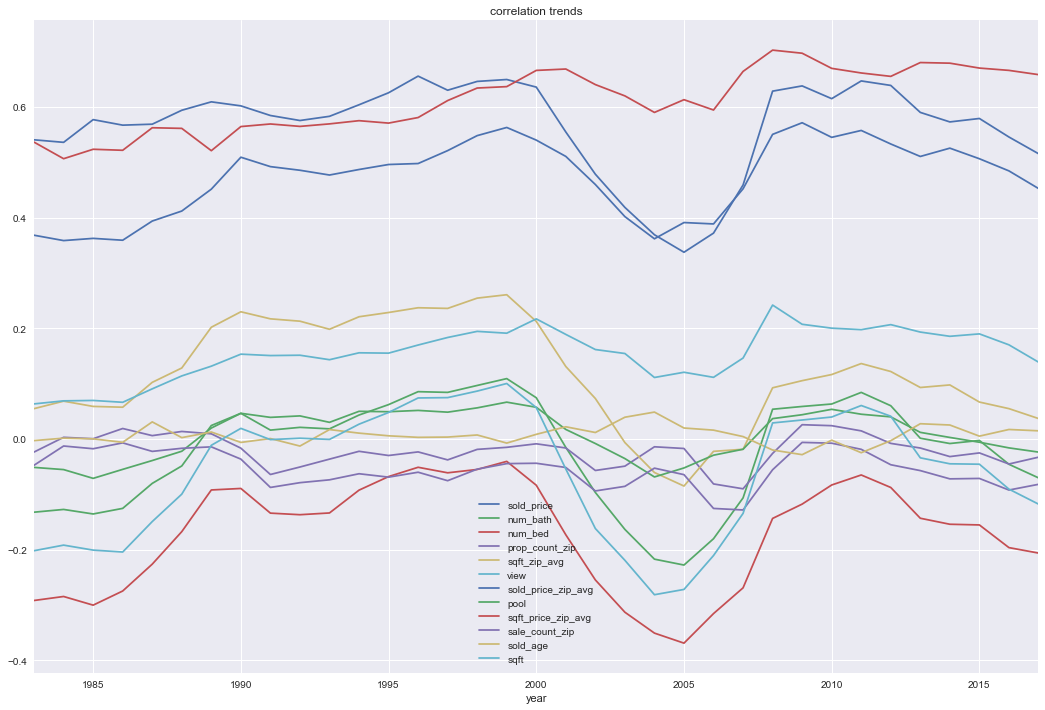

In [8]:
df_corr_all = pd.DataFrame(corrs).set_index(['year'])
plot_trends(df_corr_all, features, 'correlation trends')

### sqft price trend per brackets on features
* Features used for bracket method: sqft, sold_age, dist_to_coast
* bracket method
  * segment continuous numeric feature into brackets based on quantile
  * Compute the average sqft price for each bracket on each year
  * Cluster the brackets based on their sqft price yearly sequence

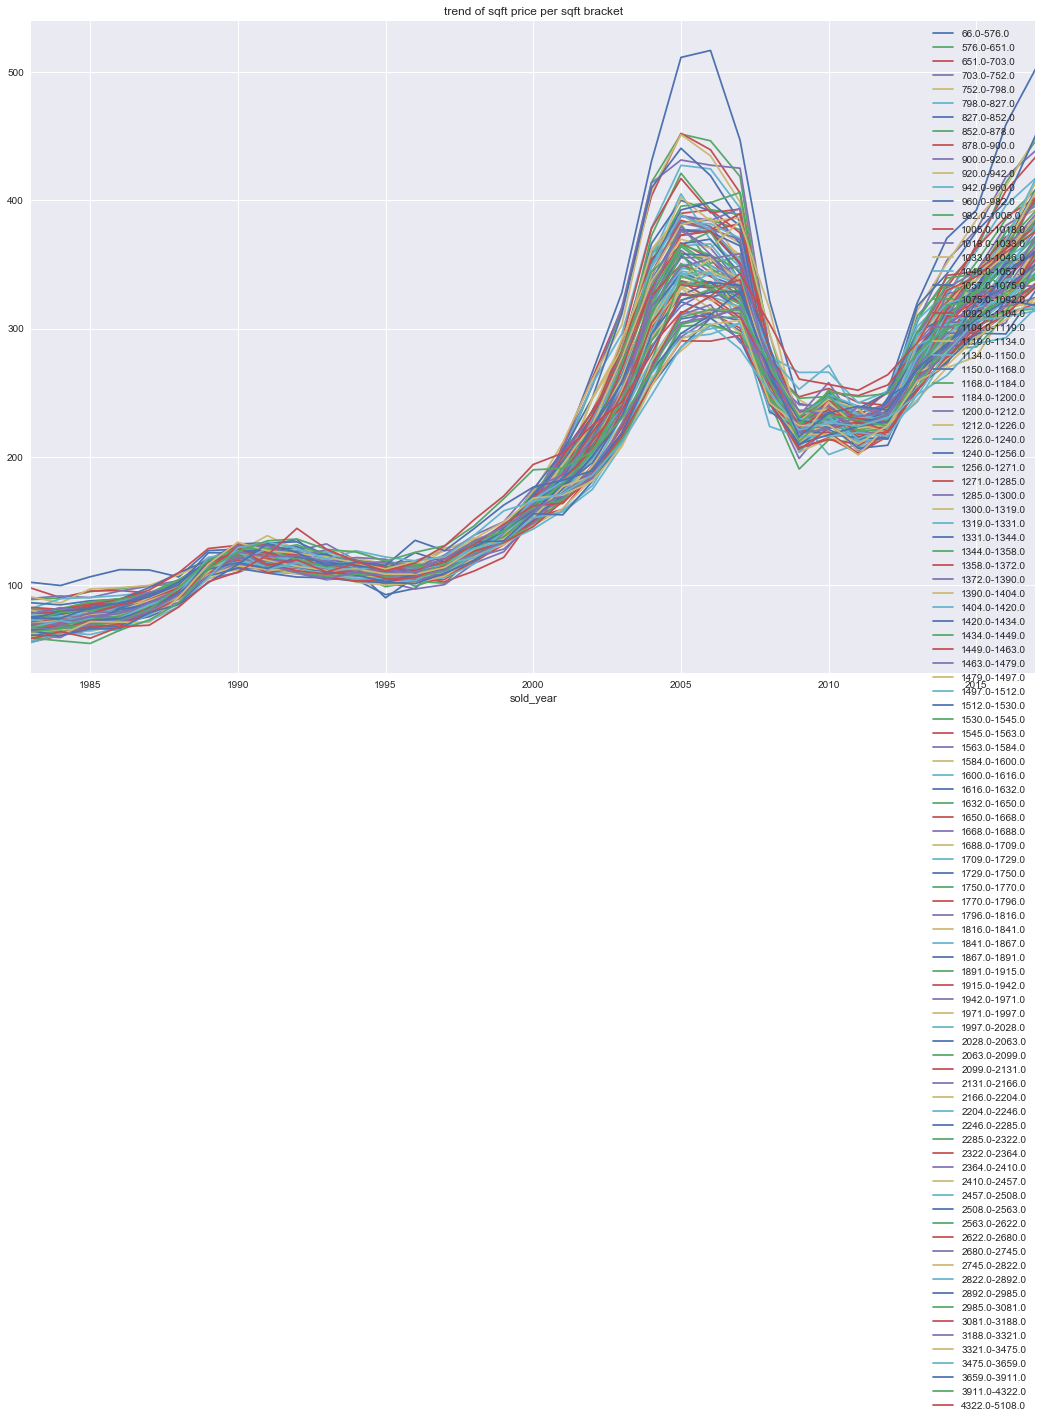

In [9]:
# segmented by sqft range
num_brackets = 100
sqft_segments = [df_all_valid['sqft'].quantile(i/num_brackets) for i in range(num_brackets)]

count = []
data = []
fig, ax = plt.subplots(figsize=(18,12))
for i in range(len(sqft_segments)-1):
    sqft_b,sqft_e = sqft_segments[i], sqft_segments[i+1]
    df_sqft_seg = df_all_valid[(df_all_valid['sqft']>=sqft_b) & (df_all_valid['sqft']<sqft_e)]
    
    bracket = df_sqft_seg.groupby(by=['sold_year'])['sqft_price']
    name = "{}-{}".format(sqft_b,sqft_e)
    #print(name, df_sqft_seg.shape[0])
    bracket_count = pd.Series(bracket.count(), name=name)
    count.append(bracket_count)
    df_sqft_seg = bracket.mean()
    data.append(pd.Series(df_sqft_seg, name=name))
    df_sqft_seg.plot(ax=ax, kind='line', label=name)
plt.legend(loc='best')
plt.title("trend of sqft price per sqft bracket")
plt.show()

df_heat = pd.concat(count, axis=1, keys=[s.name for s in count])
df_trend = pd.concat(data, axis=1)

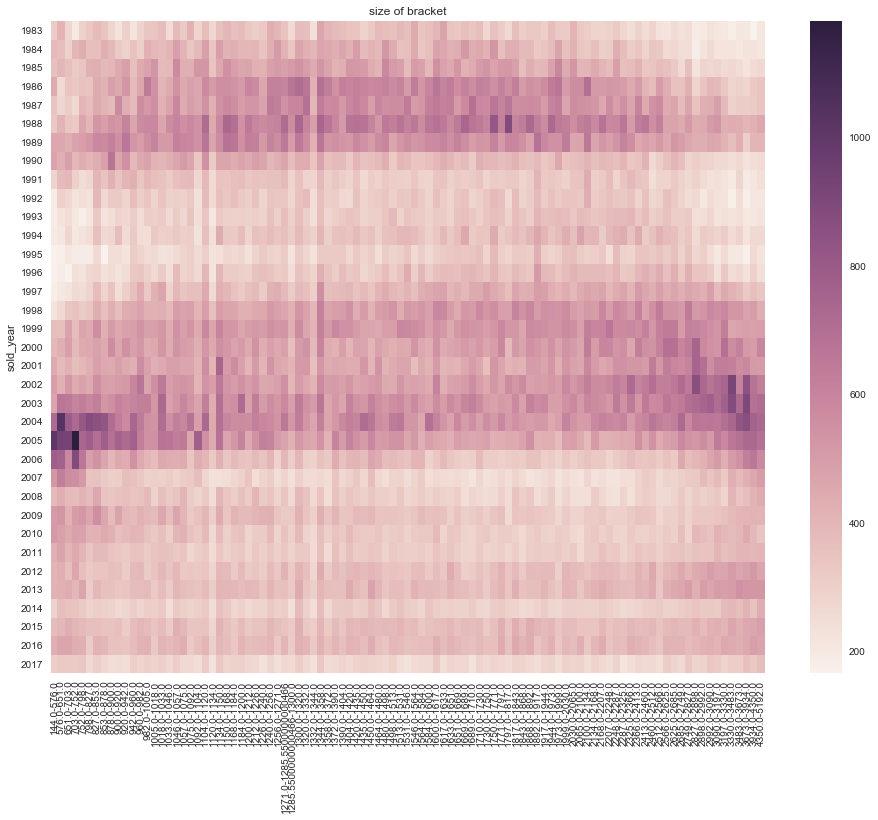

In [114]:
fig,ax = plt.subplots(figsize=(16,12))
ax.set_title('size of bracket')
hm = sns.heatmap(df_heat, ax=ax, annot=False, fmt="d")
plt.show()

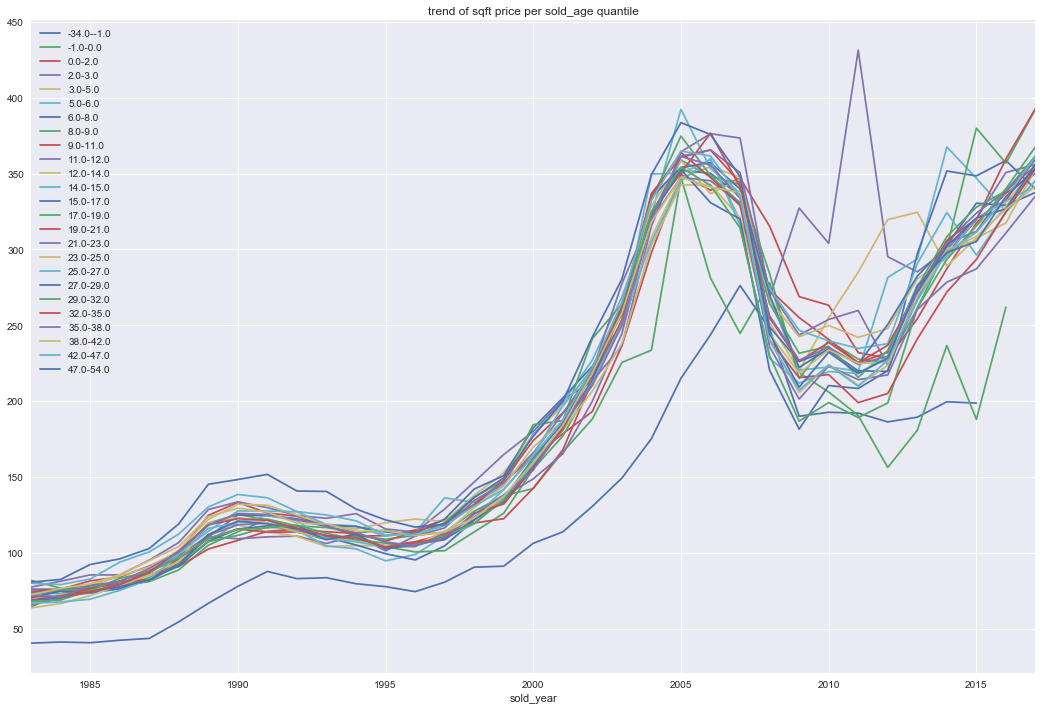

In [116]:
# bracket by sold_age
# NOTE: feature year_built is not clean, and same issue on sold_age

num_brackets = 30
year_segments = set([df_all_valid['sold_age'].quantile(i/num_brackets) for i in range(num_brackets)])
year_segments = sorted(list(year_segments))
count = []
data = []
fig, ax = plt.subplots(figsize=(18,12))
for i in range(len(year_segments)-1):
    year_b,year_e = year_segments[i], year_segments[i+1]
    df_year_seg = df_all_valid[(df_all_valid['sold_age']>=year_b) & (df_all_valid['sold_age']<year_e)]
    
    bracket = df_year_seg.groupby(by=['sold_year'])['sqft_price']
    name = "{}-{}".format(year_b,year_e)
    #print(name, df_year_seg.shape[0])
    bracket_count = pd.Series(bracket.count(), name=name)
    count.append(bracket_count)
    df_year_seg = bracket.mean()
    data.append(pd.Series(df_year_seg, name=name))
    df_year_seg.plot(ax=ax, kind='line', label=name)
plt.legend(loc='best')
plt.title("trend of sqft price per sold_age quantile")
plt.show()

df_heat_year = pd.concat(count, axis=1, keys=[s.name for s in count])
df_trend = pd.concat(data, axis=1)